<a href="https://colab.research.google.com/github/Bipolar-Ochka/Test_stand/blob/main/test_stand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Программа

## 1. Импорты


In [ ]:
import numpy as np
import numpy.ma as ma
from scipy.linalg import hadamard
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
from collections import Counter
import random
import string as string_module
from typing import List, Dict




---



## 2. Вспомогательные функции

### 2.1. Текст в выбранной кодировке -> массив выбранного типа

По умолчанию: кодировка - **windows-1251**, тип выходных переменных - **bool**. Последнее для удобства маскирования матрицы преобразования.

In [ ]:
def text2bin(text, encoding = 'windows-1251'):
    res = []
    for num in text.encode(encoding):
        res.extend(i for i in map(int, '{:08b}'.format(num)))
    
    return res

def gettextarray(text, encoding = 'windows-1251', type = 'bool'):
    result = np.array(text2bin(text, encoding), dtype=type)
    return (result, result.shape[0])

### 2.2. Битовые операции для разных нумераций матрицы преобразования

In [ ]:
#число -> код грея
def b2gr(n):
    return n ^ (n >> 1)

#код грея -> число
def gr2b(n):
    temp = n
    n >>= 1
    while n != 0:
        temp ^= n
        n >>= 1
        
    return temp

#биты в обратном порядке
def reverse(n, bits):
    b = format(n, 'b')
    b = b.rjust(bits, '0')
    return int(b[::-1],2)

#нумерация по адамару -> по уолшу
def had2wal(val, bits):
    r = reverse(val, bits)
    return gr2b(r)

#нумерация по уолшу -> по пэли
def wal2pal(val):
    return b2gr(val)

### 2.3. Вычисление матрицы преобразования заданного размера

Использовать функцию - get_ort_matrix. Первый параметр - длина массива битов кодируемого сообщения, второй - тип нумерации: 'had' - по Адамару, 'wal'  - по Уолшу, остальное - по Пэли. Возвращает матрицу ортогонального преобразования размера $2^{⌈\log_2 N⌉}$ , где N - длина массива битов сообщения

In [ ]:
def get_hadamar(size):
    return hadamard(size)

def get_walsh(size):
    bits = int(np.log2(size))
    had_mat = get_hadamar(size)
    map_wal = {i:had2wal(i, bits) for i in range(size)}
    w = np.zeros((size,size))
    for had, wal in map_wal.items():
        w[wal] = had_mat[had]
    return w

def get_paley(size):
    walsh = get_walsh(size)
    map_pal = {i:wal2pal(i) for i in range(size)}
    p = np.zeros((size,size))
    for wal, pal in map_pal.items():
        p[pal] = walsh[wal]
    return p

def get_ort_matrix(msg_len, type='pal'):
    size = np.ceil(np.log2(msg_len))
    total_size = int(2**size)

    if type == 'had':
        return (total_size, get_hadamar(total_size))
    elif type == 'wal':
        return (total_size, get_walsh(total_size))
    else:
        return (total_size, get_paley(total_size))

def get_full_ort_matrix(size, type = 'pal'):
    if type == 'had':
        return get_hadamar(size)
    elif type == 'wal':
        return  get_walsh(size)
    else:
        return get_paley(size)

def get_part_ort_matrix(size, msg_len, shift_f, shift_e, type = 'pal'):
    if type == 'had':
        return get_hadamar(size)[shift_f : msg_len+shift_f, shift_e : msg_len + shift_e]
    elif type == 'wal':
        return  get_walsh(size)[shift_f : msg_len+shift_f, shift_e : msg_len + shift_e]
    else:
        return get_paley(size)[shift_f : msg_len+shift_f, shift_e : msg_len + shift_e]

### 2.4. Задание соответствия i-му биту массива сообщений -> строки матрицы преобразования

Вход - длина массива битов сообщения. По умолчанию - i-ый бит сообщения соответствует i-ой строке матрицы преобразования

In [ ]:
def get_default_map(msg_len):
    return np.array([i for i in range(msg_len)], dtype='int')

### 2.5. Вычисление суммарного сигнала соответствующего массиву битов сообщения

Использовать - get_sum_function_for_message. Параметры - полная матрица преобразования, массив битов, соответствие из [2.4.](https://colab.research.google.com/drive/1i-hgvaiHeT_Z5MM7c-SuDrc3TxKRR-c2#scrollTo=fV20kWHF2kOH&line=1&uniqifier=1), сдвиг по строкам, сдвиг по столбцам

In [ ]:
def get_walsh_part(arr, msg_len, offset_fun = 0, offset_elem = 0):
    np_arr = np.array(arr, dtype='int')
    
    if(np_arr.ndim != 2):
        raise ValueError('Not 2 dim matrix')

    if(np_arr.shape[0] < msg_len):
        raise ValueError('Not enough functions or function elements')

    return arr[offset_fun : msg_len+offset_fun, offset_elem : msg_len + offset_elem]

def get_mapped_walsh(part_walsh, mapping):
    if(part_walsh.shape[0] < len(mapping)):
        raise ValueError('Matrix have lesser function than requested')
    return np.take(part_walsh, mapping, axis=0)

def get_walsh_masked_for_message(w_matrix, msg_bits, w_fun_mapping , offset_fun = 0, offset_elem = 0):
    msg_len = len(msg_bits)
    full_part_matrix = get_walsh_part(w_matrix, msg_len, offset_fun, offset_elem)
    part_matrix = get_mapped_walsh(full_part_matrix, w_fun_mapping)
    mask = np.array(msg_bits, dtype='bool')
    return full_part_matrix, part_matrix[mask, :]

def get_sum_function_for_message(w_matrix, msg_bits, w_fun_mapping , offset_fun = 0, offset_elem = 0):
    full_part_matrix, mtrx = get_walsh_masked_for_message(w_matrix, msg_bits, w_fun_mapping , offset_fun, offset_elem)
    return (full_part_matrix, np.sum(mtrx, axis=0))

### 2.6. Суммарный сигнал -> Массив битов сообщения

In [ ]:
def decode_sum_fun(part_matrix, sum_fun):
    return np.matmul(part_matrix, sum_fun) / part_matrix.shape[1]

### 2.7. Модель выходных данных

In [ ]:
class Result():

    def __init__(self, b_m_l, ort_m_s, s_f, s_e, b_m, d_m, m_type, sum_sig):
        #длина массива битов исходного сообщения
        self.binary_message_len = b_m_l

        #размер матрицы ортогонального преобразования     
        self.ort_matrix_size = ort_m_s

        #сдвиг по строке
        self.shift_function = s_f

        #сдвиг по столбцу
        self.shift_element = s_e

        #массив битов исходного сообщения
        self.binary_message = b_m

        #декодированное сообщение
        self.decoded_message = d_m

        #тип нумерации матрицы ортогонального преобразования
        self.matrix_type = m_type

        #суммарный сигнал
        self.summary_signal = sum_sig

    def get_full_matrix(self):
        return get_full_ort_matrix(self.ort_matrix_size, self.matrix_type)

    def get_part_matrix(self):
        return get_part_ort_matrix(self.ort_matrix_size, self.binary_message_len, self.shift_function, self.shift_element, self.matrix_type)

    def get_max_deltas(self):
        masked_arr_1 = ma.masked_where(self.binary_message != 1, self.binary_message)
        max_abs_diff_1 = (np.absolute(masked_arr_1 - self.decoded_message)).max()

        masked_arr_0 = ma.masked_where(self.binary_message != 0, self.binary_message)
        max_abs_diff_0 = (np.absolute(masked_arr_0 - self.decoded_message)).max()
        return (max_abs_diff_0, max_abs_diff_1)


class Result_full():

      def __init__(self, result_short: Result, bits_per_level, level_map, full_encoded_message):

          #Result как выше
          self.base_result = result_short

          #битов на один отсчет суммарного сигнала
          self.bits_per_signal_level = bits_per_level

          #соответствие уровень суммарного сигнала -> двоичный код
          self.level_2_binary_map = level_map

          #полностью закодированное сообщение
          self.full_encoded_message = full_encoded_message


### 2.8. Массив битов сообщения -> суммарный сигнал -> декодированный массив битов

In [ ]:
def encoder_decoder_short(binary_array, binary_msg_len, full_orthogonal_matrix, offset_f, offset_e):

    #соответствие биту сообщения функции уолша 
    #i-ый индекс массива = i-ый бит сообщения -> walsh_map[i] - номер функции уолша для i-го бита
    walsh_map = get_default_map(binary_msg_len)

    #сумма функций уолша для подматрицы
    part_matrix, sum_fun = get_sum_function_for_message(full_orthogonal_matrix, binary_array, walsh_map, offset_f, offset_e)

    #восстановление двоичного массива исходного текста
    decoded_binary_arr = np.matmul(part_matrix, sum_fun) / part_matrix.shape[1]

    return decoded_binary_arr, sum_fun

### 2.9. Уровень суммарного сигнала -> двоичная комбинация

In [ ]:
def get_level_binary_map(min_val, max_val):
    if(min_val > max_val):
        raise ValueError('min_val > max_val')

    bit_length =  math.ceil(math.log2(max_val - min_val + 1))
    format_str = f'{{:0{bit_length}b}}'
    return (bit_length, {val: format_str.format(i) for i, val in  enumerate(range(min_val, max_val+1))})

def sum_fun_to_binary_array(sum_fun, mapping):
    return [mapping[key] for key in sum_fun]

def sum_fun_to_binary_string(sum_fun, mapping):
    return ''.join([str(i) for i in sum_fun_to_binary_array(sum_fun, mapping)])

def array_to_binary_string(array):
    return ''.join([str(i) for i in array])

### 2.10. Генератор случайных строк

In [ ]:
def random_string(letter_count, digit_count):
    str1 = ''.join((random.choice(string_module.ascii_letters) for x in range(letter_count))) 
    str1 += ''.join((random.choice(string_module.digits) for x in range(digit_count))) 
    
    sam_list = list(str1) # it converts the string to list. 
    random.shuffle(sam_list) # It uses a random.shuffle() function to shuffle the string. 
    final_string = ''.join(sam_list) 
    return final_string 

def get_list_of_random_strings(numberof_strings, letter_count, digit_count):
    return [random_string(letter_count, digit_count) for i in range(numberof_strings)]

## 3. Функции кодирования/декодирования

### 3.1. Минимизируемая оценка 

Ищем такой декодированный массив для которого $∑_{i=0}^{N} (V_i - D_i)^2 → min$ , где 𝑁 - число битов сообщения, 𝑉 - массив битов входного сообщения, 𝐷 - массив декодированного сообщения

In [ ]:
def score(input_arr, output_arr):
    return (np.square(input_arr - output_arr)).sum()

### 3.2. Укороченные функции кодирования/декодирования (без перевода суммарного сигнала в набор двоичных комбинаций)

#### 3.2.1. Функция поиска оптимального подмассива в полной ортогональной матрицы в выбранной нумерации и кодировке исходного текста для сообщения произвольной длины

Поддерживается кодировка впринципе любая 8-битная кодировка, пока что.
'had' - нумерация Адамара, 'wal' - Уолша, 'pal' и любое и другое значение - Пэли

In [ ]:
def short_get_optimal_function(string, matrix_type = 'pal', encoding = 'windows-1251'):

    #текст в виде массива битов в кодировке windows-1251
    binary_array, binary_msg_len = gettextarray(string, encoding)
    output = np.array(binary_array, dtype='int')

    #полная матрица функций уолша - размер ort_matrix_size = 2 ^ (ceil(log2(binary_msg_len)))
    ort_matrix_size, full_orthogonal_matrix = get_ort_matrix(binary_msg_len, matrix_type)

    min_f, min_e = (0, 0)
    current_min = 99999
    min_decoded = np.zeros((binary_msg_len,))
    min_sum_signal = np.zeros((binary_msg_len,))

    for shift_f in range(0, ort_matrix_size - binary_msg_len + 1):
        for shift_e in range(0, ort_matrix_size - binary_msg_len + 1):
             decoded, sum_signal = encoder_decoder_short(binary_array, binary_msg_len, full_orthogonal_matrix, shift_f, shift_e)
             score_val = score(binary_array, decoded)

             if score_val < current_min:
                current_min = score_val
                min_f = shift_f
                min_e = shift_e
                min_decoded = decoded
                min_sum_signal = sum_signal

    result = Result(binary_msg_len, ort_matrix_size, min_f, min_e, output, min_decoded, matrix_type, min_sum_signal)

    return result

#### 3.2.2. Аналогично прошлому пункту, только вместо поиска - сдвиг задается вручную через параметры функции

In [ ]:
def short_get_selected_function(string, shift_f, shift_e, matrix_type = 'pal', encoding = 'windows-1251'):

    #текст в виде массива битов в кодировке windows-1251
    binary_array, binary_msg_len = gettextarray(string, encoding)
    output = np.array(binary_array, dtype='int')

    #полная матрица функций уолша - размер ort_matrix_size = 2 ^ (ceil(log2(binary_msg_len)))
    ort_matrix_size, full_orthogonal_matrix = get_ort_matrix(binary_msg_len, matrix_type)

    decoded, sum_signal = encoder_decoder_short(binary_array, binary_msg_len, full_orthogonal_matrix, shift_f, shift_e)

    result = Result(binary_msg_len, ort_matrix_size, shift_f, shift_e, output, decoded, matrix_type, sum_signal)

    return result

### 3.3. Полные функции кодирования/декодирования (с формированием итогового двоичного закодированного сообщения)

#### 3.3.1. С поиском оптимального подмассива.

In [ ]:
def full_get_optimal_function(string, matrix_type = 'pal', encoding = 'windows-1251'):
    short_result = short_get_optimal_function(string, matrix_type, encoding)

    #соответствие уровень суммарной функции -> двоичный код
    bits_per_level, level_map = get_level_binary_map(short_result.summary_signal.min(), summary_signal.max())

    #суммарная функция -> двоичный код 
    binary_encoded_array = sum_fun_to_binary_array(short_result.summary_signal, level_map)

    return Result_full(short_result, bits_per_level, level_map, binary_encoded_array)


#### 3.3.2. Без поиска

In [ ]:
def full_get_selected_function(string, shift_f, shift_e, matrix_type = 'pal', encoding = 'windows-1251'):
    short_result = short_get_selected_function(string, shift_f, shift_e, matrix_type, encoding)

    #соответствие уровень суммарной функции -> двоичный код
    bits_per_level, level_map = get_level_binary_map(short_result.summary_signal.min(), summary_signal.max())

    #суммарная функция -> двоичный код 
    binary_encoded_array = sum_fun_to_binary_array(short_result.summary_signal, level_map)

    return Result_full(short_result, bits_per_level, level_map, binary_encoded_array)


## 4. Отображение результатов

### 4.1. Графическое отображение результатов

#### 4.1.1. Для одного выходного объекта

In [ ]:
def plot_result(result: Result):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (16,6))
    mes_len = result.binary_message_len
    p_m = result.get_part_matrix()
    ax[0].imshow(p_m, interpolation='none', cmap='binary')
    ax[0].set(xlabel = 'Элемент функции', ylabel = 'Номер функции', title = f'Исходный текст = {mes_len} битов.\ndelta = {result.ort_matrix_size - mes_len}\n Нумерация {get_matr_name(result.matrix_type)}')
    plt.setp(ax[0], xticks = [i for i in range(0, p_m.shape[0])], xticklabels = [i for i in range(1, p_m.shape[0]+1)], yticks = [i for i in range(0, p_m.shape[0])], yticklabels = [i for i in range(1, p_m.shape[0]+1)])
    plt.setp(ax[0].get_xticklabels(), fontsize=6, rotation=90)
    plt.setp(ax[0].get_yticklabels(), fontsize=6)

    full_m = result.get_full_matrix()
    ax[1].imshow(full_m, interpolation='none', cmap='binary')
    ax[1].set(xlabel = 'Элемент функции', ylabel = 'Номер функции', title = f'Сдвиг по функциям = {result.shift_function}\nПо элементам = {result.shift_element}')
    plt.setp(ax[1], xticks = [i for i in range(0, result.ort_matrix_size)], xticklabels = [i for i in range(1, result.ort_matrix_size+1)], yticks = [i for i in range(0, result.ort_matrix_size)], yticklabels = [i for i in range(1, result.ort_matrix_size+1)])
    plt.setp(ax[1].get_xticklabels(), fontsize=6, rotation=90)
    plt.setp(ax[1].get_yticklabels(), fontsize=6)
    cb = Rectangle((-.4 + result.shift_element,-.4 + result.shift_function),p_m.shape[0],p_m.shape[1],
                            edgecolor='red',
                            facecolor='none',
                            lw=1)
    ax[1].add_patch(cb)

    ax[2].plot(result.binary_message, 'r+')
    ax[2].plot(result.decoded_message, 'b.')

    ax[2].plot(([i for i in range(result.binary_message_len)], [i for i in range(result.binary_message_len)]), (result.binary_message, result.decoded_message), c='black')

    max_abs_diff_0, max_abs_diff_1 = result.get_max_deltas()

    ax[2].set(title = f'Max delta for 1 = {max_abs_diff_1:.3f}, \n max delta for 0 = {max_abs_diff_0:.3f}\n Оценка расхождений = {score(result.binary_message, result.decoded_message)}')
    
    plt.tight_layout()
    plt.show()

#### 4.1.2. Для списка объектов

In [ ]:
def plot_list_result(results):
    fig, ax = plt.subplots(nrows=len(results), ncols=3, figsize = (16,6*len(results)))
    for i, result in enumerate(results):
      mes_len = result.binary_message_len
      p_m = result.get_part_matrix()
      ax[i,0].imshow(p_m, interpolation='none', cmap='binary')
      ax[i,0].set(xlabel = 'Элемент функции', ylabel = 'Номер функции', title = f'Исходный текст = {mes_len} битов.\ndelta = {result.ort_matrix_size - mes_len}\nНумерация {get_matr_name(result.matrix_type)}')
      plt.setp(ax[i,0], xticks = [i for i in range(0, p_m.shape[0])], xticklabels = [i for i in range(1, p_m.shape[0]+1)], yticks = [i for i in range(0, p_m.shape[0])], yticklabels = [i for i in range(1, p_m.shape[0]+1)])
      plt.setp(ax[i,0].get_xticklabels(), fontsize=6, rotation=90)
      plt.setp(ax[i,0].get_yticklabels(), fontsize=6)

      full_m = result.get_full_matrix()
      ax[i,1].imshow(full_m, interpolation='none', cmap='binary')
      ax[i,1].set(xlabel = 'Элемент функции', ylabel = 'Номер функции', title = f'Сдвиг по функциям = {result.shift_function}\nПо элементам = {result.shift_element}')
      plt.setp(ax[i,1], xticks = [i for i in range(0, result.ort_matrix_size)], xticklabels = [i for i in range(1, result.ort_matrix_size+1)], yticks = [i for i in range(0, result.ort_matrix_size)], yticklabels = [i for i in range(1, result.ort_matrix_size+1)])
      plt.setp(ax[i,1].get_xticklabels(), fontsize=6, rotation=90)
      plt.setp(ax[i,1].get_yticklabels(), fontsize=6)
      cb = Rectangle((-.4 + result.shift_element,-.4 + result.shift_function),p_m.shape[0],p_m.shape[1],
                              edgecolor='red',
                              facecolor='none',
                              lw=1)
      ax[i,1].add_patch(cb)

      ax[i,2].plot(result.binary_message, 'r+')
      ax[i,2].plot(result.decoded_message, 'b.')

      ax[i,2].plot(([i for i in range(result.binary_message_len)], [i for i in range(result.binary_message_len)]), (result.binary_message, result.decoded_message), c='black')

      max_abs_diff_0, max_abs_diff_1 = result.get_max_deltas()

      ax[i,2].set(title = f'Max delta for 1 = {max_abs_diff_1:.3f}, \n max delta for 0 = {max_abs_diff_0:.3f}\n Оценка расхождений = {score(result.binary_message, result.decoded_message)}')
    
    plt.tight_layout()
    plt.show()

#### 4.1.3. Отображение карты сдвигов

In [ ]:
def plot_shift_map(res_list : List[Result]):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    point_list = [(res.shift_element,res.shift_function) for res in res_list]
    x = [x for x,y in point_list]
    y = [y for x,y in point_list]
    D = Counter(point_list)
    ax[0].bar([f'{x}:{y}' for x,y in D.keys()], list(D.values()), align='center')
    ax[0].set(xlabel = 'Вариант сдвига (Строка)х(Столбец)', ylabel = 'Количество примеров')

    ax[1].plot([score(res.binary_message, res.decoded_message) for res in res_list])
    ax[1].set(xlabel = 'Индекс сообщения', ylabel = 'Величина оценки')

    plt.show()


### 4.2. Текстовый вывод

In [ ]:
def get_matr_name(short_name):
    if short_name == 'had':
      return 'Адамара'
    elif short_name == 'wal':
      return 'Уолша'
    else:
      return 'Пэли'


def print_all_text_result(result: Result):
    print(f'Длина сообщения = {result.binary_message_len} бит')
    print(f'Сообщение: {result.binary_message}')
    print(f'Используется матрица {result.ort_matrix_size}x{result.ort_matrix_size} в нумерации {get_matr_name(result.matrix_type)}')
    print(f'Сдвиг: {result.shift_function}x{result.shift_element} (по строке х по столбцу) ')
    print(f'Суммарный сигнал: {result.summary_signal}')
    print(f'Декодированное сообщение: {result.decoded_message}')

def print_min_text_result(result :Result):
    max_0, max_1 = result.get_max_deltas()
    print(f'Сдвиг: {result.shift_function}x{result.shift_element}')
    print(f'Макс отклонение для 0 = {max_0}')
    print(f'Макс отклонение для 1 = {max_1}')

## 5. Основные функции (вынес вызовы для удобства)

### 5.1. Перечисление доступных функций

In [ ]:
#возвращает объект типа Result - п. 2.7.
def короткое_кодирование_с_поиском(сообщение_строкой, нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> Result:
    return short_get_optimal_function(сообщение_строкой, нумерация_матрицы, кодировка)

#возвращает список объектов типа Result - п. 2.7.
def короткое_кодирование_с_поиском_массовое(список_сообщений_строкой : List[str], нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> List[Result]:
    return [short_get_optimal_function(s, нумерация_матрицы, кодировка) for s in список_сообщений_строкой]


#возвращает список объектов типа Result - п. 2.7.
def короткое_кодирование_с_поиском_массовое_разная_нумерация(список_сообщений_строкой : Dict[str, str], нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> List[Result]:
    return [short_get_optimal_function(s, c, кодировка) for s, c in список_сообщений_строкой.items()]


#возвращает объект типа Result - п. 2.7.
def короткое_кодирование_с_заданным_сдвигом(сообщение_строкой, сдвиг_строка, сдвиг_столбец, нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> Result:
    return short_get_selected_function(сообщение_строкой, сдвиг_строка, сдвиг_столбец, нумерация_матрицы, кодировка)


#возвращает список объектов типа Result - п. 2.7.
def короткое_кодирование_с_заданным_сдвигом_массовое(список_сообщений_строкой : List[str], сдвиг_строка, сдвиг_столбец, нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> List[Result]:
    return [short_get_selected_function(s, сдвиг_строка, сдвиг_столбец, нумерация_матрицы, кодировка) for s in список_сообщений_строкой]


#возвращает список объектов типа Result - п. 2.7.
def короткое_кодирование_с_заданным_сдвигом_массовое_разная_нумерация(список_сообщений_строкой : Dict[str, str], сдвиг_строка, сдвиг_столбец, нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> List[Result]:
    return [short_get_selected_function(s, сдвиг_строка, сдвиг_столбец, c, кодировка) for s, c in список_сообщений_строкой.items()]


#возвращает объект типа Result_full - п. 2.7.
def полное_кодирование_с_поиском(сообщение_строкой, нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> Result_full:
    return full_get_optimal_function(сообщение_строкой, нумерация_матрицы, кодировка)

#возвращает список объектов типа Result_full - п. 2.7.
def полное_кодирование_с_поиском_массовое(список_сообщений_строкой : List[str], нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> List[Result_full]:
    return [full_get_optimal_function(s, нумерация_матрицы, кодировка) for s in список_сообщений_строкой]


#возвращает список объектов типа Result_full - п. 2.7.
def полное_кодирование_с_поиском_массовое_разная_нумерация(список_сообщений_строкой : Dict[str, str], нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> List[Result_full]:
    return [full_get_optimal_function(s, c, кодировка) for s, c in список_сообщений_строкой.items()]


#возвращает объект типа Result_full - п. 2.7.
def полное_кодирование_с_заданным_сдвигом(сообщение_строкой, сдвиг_строка, сдвиг_столбец, нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> Result_full:
    return full_get_selected_function(сообщение_строкой, сдвиг_строка, сдвиг_столбец, нумерация_матрицы, кодировка)


#возвращает список объектов типа Result - п. 2.7.
def полное_кодирование_с_заданным_сдвигом_массовое(список_сообщений_строкой : List[str], сдвиг_строка, сдвиг_столбец, нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> List[Result_full]:
    return [full_get_selected_function(s, сдвиг_строка, сдвиг_столбец, нумерация_матрицы, кодировка) for s in список_сообщений_строкой]


#возвращает список объектов типа Result - п. 2.7.
def полное_кодирование_с_заданным_сдвигом_массовое_разная_нумерация(список_сообщений_строкой : Dict[str, str], сдвиг_строка, сдвиг_столбец, нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> List[Result_full]:
    return [full_get_selected_function(s, сдвиг_строка, сдвиг_столбец, c, кодировка) for s, c in список_сообщений_строкой.items()]


def короткое_кодирование_по_всем_подматрицам(сообщение_строкой, нумерация_матрицы = 'pal', кодировка = 'windows-1251') -> List[Result]:
    res_opt = short_get_optimal_function(сообщение_строкой, нумерация_матрицы, кодировка)
    res_full = []

    for i in range(0, res_opt.ort_matrix_size - res_opt.binary_message_len + 1):
        for j in range(0, res_opt.ort_matrix_size - res_opt.binary_message_len + 1):
            res_full.append(short_get_selected_function(сообщение_строкой, i, j, нумерация_матрицы, кодировка))

    return res_full


def получить_случайную_строку(количество_символов_в_строке, количество_цифр_в_строке) -> str:
    return random_string(количество_символов_в_строке, количество_цифр_в_строке)


def получить_массив_случайных_строк(количество_строк, количество_символов_в_строке, количество_цифр_в_строке) -> List[str]:
    return get_list_of_random_strings(количество_строк, количество_символов_в_строке, количество_цифр_в_строке)


#только для одного объекта
def график_одного_результата(объект_Result : Result):
    return plot_result(объект_Result)


#только для списка объектов
def график_списка_результатов(список_Result : List[Result]):
    return plot_list_result(список_Result)


def график_списка_сдвиги(список_Result : List[Result]):
    return plot_shift_map(список_Result)


def текстовый_вывод_результата(результат : Result):
    return print_all_text_result(результат)


def текстовый_вывод_результата_краткий(результат : Result):
    return print_min_text_result(результат)

# Использование программы

## Документация


ВОЗМОЖНЫЕ ТИПЫ НУМЕРАЦИЙ
1.   Адамар - 'had'
2.   Уолш - 'wal'
3.   Пэли - 'pal' или любое другое значение



**Доступные функции (объявления в п. 5.1.)**


Функции по кодированию / декодированию без перевода суммарного сигнала в двоичные комбинации:
1.   `короткое_кодирование_с_поиском('сообщение', 'had')` - с поиском оптимального подмассива в нумерации Адамара
2.   `короткое_кодирование_с_поиском_массовое(['сообщение1', 'сообщение2'])` - с поиском для массива в нумерации Пэли
3.   `короткое_кодирование_с_поиском_массовое_разная_нумерация({'сообщение1':'had', 'сообщение2':'wal'})` - с поиском для словаря, первое сообщение в нумерации Адамара, а второе по Уолшу
4. `короткое_кодирование_с_заданным_сдвигом('сообщение', 1, 2)` - без поиска со сдвигом кодирующей матрицы на один по строке и 2 по столбцу в нумерации Пэли
5. `короткое_кодирование_с_заданным_сдвигом_массовое([тест1, тест2], 1, 2)` - аналогично предыдущему но для массива
6. `короткое_кодирование_с_заданным_сдвигом_массовое_разная_нумерация({'сообщение1':'had', 'сообщение2':'wal'}, 2, 3)` - аналогично п.3. но с заданным сдвигом
7. `полное_кодирование_с_поиском('сообщение', 'had')` - аналогично п.1. но возвращает объект `Result_full` с переводом двоичные последовательности суммарного сигнала
8. `полное_кодирование_с_поиском_массовое(['сообщение1', 'сообщение2'])` - аналогично п.7. для массива
9. `полное_кодирование_с_поиском_массовое_разная_нумерация({'сообщение1':'had', 'сообщение2':'wal'})` - аналогично п.3. но с переводом двоичные последовательности суммарного сигнала
10. `полное_кодирование_с_заданным_сдвигом('сообщение', 1, 2)` - аналогично п.4. но с переводом двоичные последовательности суммарного сигнала
11. `полное_кодирование_с_заданным_сдвигом_массовое([тест1, тест2], 1, 2)`- аналогично п.5. но с переводом двоичные последовательности суммарного сигнала
12. `полное_кодирование_с_заданным_сдвигом_массовое_разная_нумерация({'сообщение1':'had', 'сообщение2':'wal'}, 2, 3)`- аналогично п.6. но с переводом двоичные последовательности суммарного сигнала

13. `короткое_кодирование_по_всем_подматрицам('test')` - короткое кодирование по всем возможным подматрицам - возвращает список результатов


Функции по генерации входных данных:
1.   `получить_случайную_строку(6,1)` - возвращает случайную строку из 6 букв и 1 цифр - итоговая длина строки = 7 символов
2.   `получить_массив_случайных_строк(6, 6,  1)` - возвращает 6 строк с аналогичными параметрами из п.1.


Функции вывода графического или текстового:
1. `график_одного_результата(результат)` - выводит графическое отображение **ТОЛЬКО ДЛЯ 1** результата типа `Result` в 3 частях - подматрица, подматрица относительно полной матрицы, сравнение сообщение до и после кодирования подматрицей
2. `график_списка_результатов(cписок)` - аналогично п.1. но **ТОЛЬКО ДЛЯ СПИСКА**
3. `текстовый_вывод_результата(результат)` - подробный вывод значений объекта типа `Result`
4. `текстовый_вывод_результата_краткий(результат)` - вывод только сдвига и максимального отклонения для 1 и 0.


Содержание результата краткой версии алгоритма `Result`
1. `Result.binary_message_len` - длина массива битов исходного сообщения
2. `Result.ort_matrix_size` - полная размерность матрицы ортогонального преобразования
3. `Result.shift_function` - оптимальный сдвиг по строке
4. `Result.shift_element`- оптимальный сдвиг по столбцу
5. `Result.binary_message` - сообщение в виде массива битов
6. `Result.decoded_message` - декодированное сообщение в виде массива float
7. `Result.matrix_type` - тип нумерации матрицы (см. выше)
8. `Result.summary_signal` - суммарный сигнал по подматрице функций Уолша
9. `Result.get_full_matrix()` - метод получения полной матрицы ортогонального преобразования 
10. `Result.get_part_matrix()` - метод получения подматрицы по заданным в объекте сдвигам
11. `Result.get_max_deltas()` - расчет максимальных отклонений декодированных значений от исходного массива битов


Содержание результата полной версии алгоритма `Result_full`
1. `Result_full.base_result` возвращает результат как для краткой версии т.е. объект типа `Result`
2. `Result_full.bits_per_signal_level` возвращает количество битов используемых для кодирования одного отсчета суммарного сигнала
3. `Result_full.level_2_binary_map` возвращает соответствие уровня суммарного сигнала двоичной комбинации
4. `Result_full.full_encoded_message` возвращает полностью закодированное сообщение


## Тестовые примеры

In [ ]:
входной_текст = 'ааааааа'
resH = короткое_кодирование_с_поиском(входной_текст, 'had')
resW = короткое_кодирование_с_поиском(входной_текст, 'wal')
resP = короткое_кодирование_с_поиском(входной_текст, 'pal')
график_списка_результатов([resH, resW, resP])



---



Тест для times_repeat случайных строк длиной num_letters + num_nums

In [ ]:
#число строк для генерации
times_repeat = 8

#число буквенных символов в случайной строке
num_letters = 7

#число цифровых символов в случайной строке
num_nums = 0

#string len total = num_letters + num_nums
input_arr = получить_массив_случайных_строк(times_repeat, num_letters, num_nums)
ress = короткое_кодирование_с_поиском_массовое(input_arr, 'wal')
plot_list_result(ress)



---



In [ ]:
#число строк для генерации
times_repeat = 40

#число буквенных символов в случайной строке
num_letters = 7

#число цифровых символов в случайной строке
num_nums = 0

input_arr = получить_массив_случайных_строк(40, 7, 0)

output_arr = короткое_кодирование_с_поиском_массовое(input_arr)

plot_shift_map(output_arr)


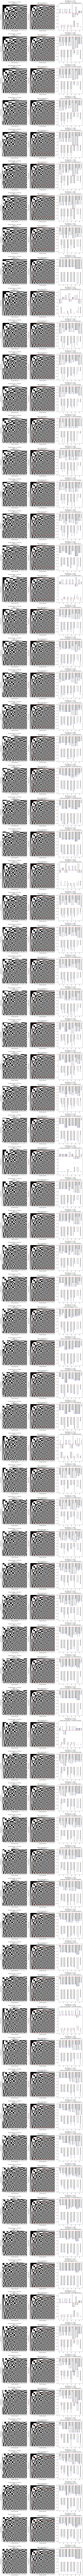

In [ ]:
input_mes = 'тестйцу'

res = короткое_кодирование_по_всем_подматрицам(input_mes)
график_списка_результатов(res)

## Рабочее пространство



---

